In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **IMPORT**

In [4]:
import tensorflow as tf
import os
import numpy as np
import json
import re
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


In [ ]:
# Path to the folder containing the images
folder_path = '/kaggle/input/dataset-vr/Dataset_VR/Images'

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Extract image IDs from filenames
img_list = [int(filename.split('.')[0]) for filename in files if filename.endswith('.jpg')]



In [ ]:
print(len(img_list))

In [ ]:
# Load the JSON data
with open('/kaggle/input/dataset-vr/Dataset_VR/v2_mscoco_train2014_annotations.json', 'r') as f:
    data = json.load(f)

filtered_annotations = [annotation for annotation in data['annotations'] if annotation['image_id'] in img_list]

# Created a new dictionary containing only the filtered annotations
filtered_data = {
    'info': data['info'],
    'license': data['license'],
    'data_subtype': data['data_subtype'],
    'annotations': filtered_annotations
}

# SaveD the filtered JSON data
with open('filtered_annotations.json', 'w') as f:
    json.dump(filtered_data, f)


In [ ]:

# Load the JSON data
with open('/kaggle/input/dataset-vr/Dataset_VR/v2_OpenEnded_mscoco_train2014_questions.json', 'r') as f:
    data = json.load(f)


# Filter questions for the image IDs in img_list
filtered_questions = [question for question in data['questions'] if question['image_id'] in img_list]

# Created a new dictionary containing only the filtered questions
filtered_data = {
    'info': data['info'],
    'task_type': data['task_type'],
    'data_type': data['data_type'],
    'license': data['license'],
    'data_subtype': data['data_subtype'],
    'questions': filtered_questions
}

# Saved the filtered JSON data
with open('filtered_questions.json', 'w') as f:
    json.dump(filtered_data, f)


# **CREATION OF FEATURE MAP USING VGG-19**


In [35]:
data_dir = "/kaggle/input/vqa-dataset-vr/"
output_dir = "/kaggle/working/"
image_dir = os.path.join(data_dir, "")
output_file = os.path.join(output_dir, "train_features.npy")
print(image_dir)
print(output_file)


target_size = (224, 224)
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #Data generator to preprocess the images
generator = datagen.flow_from_directory(
    image_dir,
    target_size=target_size,
    batch_size=32,
    class_mode=None,
    shuffle=False
)

/kaggle/input/vqa-dataset-vr/
/kaggle/working/train_features.npy
Found 20758 images belonging to 1 classes.


In [36]:
# Create an VGG19 model to extract image features
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)

In [37]:
train_features = []

for i in tqdm(range(len(generator))):   #Took around 2hr 7mins to create the features.
    batch = next(generator)  

    if isinstance(batch, tuple) and len(batch) == 2:
        images, labels = batch  
    else:
        images = batch  

    features = model.predict_on_batch(images)  # Passed the images to the model
    train_features.append(features)

# Concatenate and reshaped the extracted features into a numpy array
train_features = np.concatenate(train_features)
train_features = train_features.reshape((len(generator.filenames), -1))

# Saved the extracted features to a numpy file
np.save(output_file, train_features)


 24%|██▍       | 157/649 [01:50<05:44,  1.43it/s]


KeyboardInterrupt: 

In [ ]:
# added ids to features

img_ids = np.array([int(re.search(r"\d+", gen).group()) for gen in generator.filenames])
image_features = {}
for i in range(len(img_ids)):
    image_features[img_ids[i]] = train_features[i]


In [ ]:
#saved in a pickle file for ease of use later on
with open('train_image_features_vgg19.pkl', 'wb') as fp:
    pickle.dump(image_features, fp)
    print('saved successfully')

# **MODEL**

In [38]:
train_file_questions = '/kaggle/input/training-data/questions.json'
train_file_annotations = '/kaggle/input/training-data/annotations.json'

# Load training questions and annotations
with open(train_file_questions, 'r') as f:
    train_questions = json.load(f)['questions']

with open(train_file_annotations, 'r') as f:
    train_annotations = json.load(f)['annotations']

# Read dictionary pkl file
with open('/kaggle/input/dataset-vr/Dataset_VR/train_image_features_vgg19.pkl', 'rb') as fp:
    train_imgs_features = pickle.load(fp)
    print('successful')


successful


In [39]:
# Extract the questions and answers
questions = []
answers = []
features_id = []

for i in range(len(train_questions)):
    questions.append(train_questions[i]['question'])
    answers.append(train_annotations[i]['multiple_choice_answer'])
    features_id.append(train_questions[i]["image_id"])

In [40]:
# Tokenize the questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(questions)

max_question_length = max([len(question) for question in questions])
padded_sequences = pad_sequences(sequences, maxlen=max_question_length)

# Convert the answers to one-hot vectors
answers_tokenizer = Tokenizer()
answers_tokenizer.fit_on_texts(answers)
answer_word_index = answers_tokenizer.word_index
num_classes = len(answer_word_index)
answer_sequences = answers_tokenizer.texts_to_sequences(answers)

In [41]:
# Pad the answer sequences to ensure they all have the same length
max_answer_length = max(len(seq) for seq in answer_sequences)
padded_answers = pad_sequences(answer_sequences, maxlen=max_answer_length)

# Get the unique answers in the dataset and create a dictionary to map them to integer labels
unique_answers = list(set(answers))
label_map = {answer: i for i, answer in enumerate(unique_answers)}

# Convert the answers to integer labels and then to one-hot vectors
labels = [label_map[answer] for answer in answers]
one_hot_answers = to_categorical(labels, num_classes=len(unique_answers))

In [42]:
# Define the lengths for train, test, and validation sets
total_samples = len(features_id)
train_length = int(0.7 * total_samples)
test_length = int(0.2 * total_samples)
val_length = total_samples - train_length - test_length

#Test
test_features_id = features_id[train_length:train_length + test_length]
test_padded_sequences = padded_sequences[train_length:train_length + test_length]
test_one_hot_answers = one_hot_answers[train_length:train_length + test_length]

#Val
val_features_id = features_id[train_length + test_length:]
val_padded_sequences = padded_sequences[train_length + test_length:]
val_one_hot_answers = one_hot_answers[train_length + test_length:]

#Train
features_id = features_id[:train_length]
padded_sequences = padded_sequences[:train_length]
one_hot_answers = one_hot_answers[:train_length]


In [43]:
# Defined the model
question_input = Input(shape=(max_question_length, ), name='question_input')
image_input = Input(shape=(25088, ), name='image_input')

# Defined the embedding layer for the questions
question_embedding = Embedding(input_dim=len(word_index)+1, output_dim=300, input_length=max_question_length,
                               name='question_embedding')(question_input)

# Defined the LSTM layer for the questions
question_lstm = LSTM(units=512, name='question_lstm', return_sequences=True)(question_embedding)
question_lstm = Dropout(0.3, name='question_dropout')(question_lstm)

question_lstm2 = LSTM(units=256, name='question_lstm2')(question_lstm)
question_lstm2 = Dropout(0.2, name='question_dropout2')(question_lstm2)

# Defined the dense layer for the image features
image_dense = Dense(units=256, activation='relu', name='image_dense')(image_input)
image_dense = Dropout(0.2, name='image_dropout')(image_dense)

# Concatenated the output from the LSTM and dense layers
concatenated = concatenate([question_lstm2, image_dense], name='concatenated')

dense_cnc = Dense(units=512, activation='relu', name='dens_conc')(concatenated)
dense_cnc2 = Dense(units=512, activation='relu', name='dens_conc2')(dense_cnc)
# Defined the output layer for the classification
output = Dense(units=len(unique_answers), activation='softmax', name='output')(dense_cnc2)

# Defined the model
model = Model(inputs=[question_input, image_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_embedding  │ (None, 100, 300)  │  2,812,500 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_lstm       │ (None, 100, 512)  │  1,665,024 │ question_embeddi… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_dropout    │ (None, 100, 512)  │          0 │ question_lstm[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 25088)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_lstm2      │ (None, 256)       │    787,456 │ question_dropout… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │  6,422,784 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_dropout2   │ (None, 256)       │          0 │ question_lstm2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dropout       │ (None, 256)       │          0 │ image_dense[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated        │ (None, 512)       │          0 │ question_dropout… │
│ (Concatenate)       │                   │            │ image_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dens_conc (Dense)   │ (None, 512)       │    262,656 │ concatenated[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dens_conc2 (Dense)  │ (None, 512)       │    262,656 │ dens_conc[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 9134)      │  4,685,742 │ dens_conc2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,898,818 (64.46 MB)

 Trainable params: 16,898,818 (64.46 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Custom data generator
def data_generator(image_features, padded_questions, labels, batch_size):
    num_samples = len(labels)
    steps_per_epoch = num_samples // batch_size
    while True:
        for i in range(steps_per_epoch):
            batch_image_features = []
            for j in image_features[i*batch_size:(i+1)*batch_size]:
                batch_image_features.append(train_imgs_features[j])
            batch_padded_questions = padded_questions[i*batch_size:(i+1)*batch_size]
            batch_labels = labels[i*batch_size:(i+1)*batch_size]
            yield {'question_input': np.asarray(batch_padded_questions), 'image_input': np.asarray(batch_image_features)}, np.asarray(batch_labels)


In [115]:
# Measure the time taken for training (TTT)
start_time = time.time()

# Train the model
batch_size = 32
steps_per_epoch = len(one_hot_answers) // batch_size

checkpoint = ModelCheckpoint('VGG_lstm_15epochs.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(data_generator(features_id, padded_sequences, one_hot_answers, batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=data_generator(val_features_id, val_padded_sequences, val_one_hot_answers, batch_size),
                    validation_steps=len(val_features_id) // batch_size,
                    callbacks=[checkpoint])

end_time = time.time()
training_time = end_time - start_time

# Predict on the test dataset
test_steps = len(test_features_id) // batch_size
test_predictions = model.predict(data_generator(test_features_id, test_padded_sequences, test_one_hot_answers, batch_size), steps=test_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = np.argmax(test_one_hot_answers[:test_steps*batch_size], axis=1)

# Recreate the label map to ensure consistency
reverse_label_map = {v: k for k, v in label_map.items()}

# Compute the metrics
accuracy = accuracy_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes, average='weighted')
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')



Epoch 1/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.1998 - loss: 5.0563 - val_accuracy: 0.1804 - val_loss: 5.3838
Epoch 2/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.2070 - loss: 4.9748 - val_accuracy: 0.1845 - val_loss: 5.5498
Epoch 3/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.2123 - loss: 4.8910 - val_accuracy: 0.1796 - val_loss: 5.4413
Epoch 4/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.2160 - loss: 4.8010 - val_accuracy: 0.1937 - val_loss: 5.4919
Epoch 5/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.2219 - loss: 4.7212 - val_accuracy: 0.1827 - val_loss: 5.4975
Epoch 6/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.2239 - loss: 4.6390 - val_accuracy: 0.1909 - val_loss: 5.5536
Epoch 7/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.2237 - loss: 4.5400 - val_accuracy: 0.1877 - val_loss: 5.5727
Epoch 8/10
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.2252 -

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
print("f1:",f1)
print("precision:",precision)
print("recall:",recall)
print("accuracy:",accuracy)


f1: 0.10002329580844072
precision: 0.07117319119643728
recall: 0.18186327561327562
accuracy: 0.18186327561327562


+-------------------------------+----------------+
|             Metric            |     Value      |
+-------------------------------+----------------+
|            Accuracy           |     0.1819     |
|            F1 Score           |     0.1000     |
|           Precision           |     0.0712     |
|             Recall            |     0.1819     |
| Time Taken for Training (TTT) | 845.39 seconds |
+-------------------------------+----------------+


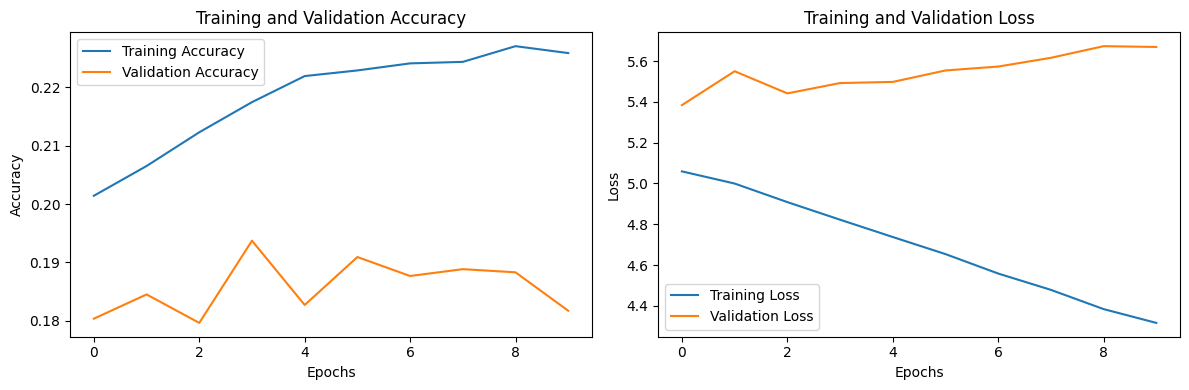

In [117]:
# Display the results in a pretty table
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Accuracy", f"{accuracy:.4f}"])
table.add_row(["F1 Score", f"{f1:.4f}"])
table.add_row(["Precision", f"{precision:.4f}"])
table.add_row(["Recall", f"{recall:.4f}"])
table.add_row(["Time Taken for Training (TTT)", f"{training_time:.2f} seconds"])

print(table)

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('VGG_lstm_all.jpg')

plt.tight_layout()
plt.show()


In [ ]:
model.save_weights('VGG_lstm_weights.h5')


# **CUSTOM TEST**

In [145]:
from PIL import Image
from IPython.display import display

i=3995
num=str(test_features_id[i])
num


'134914'

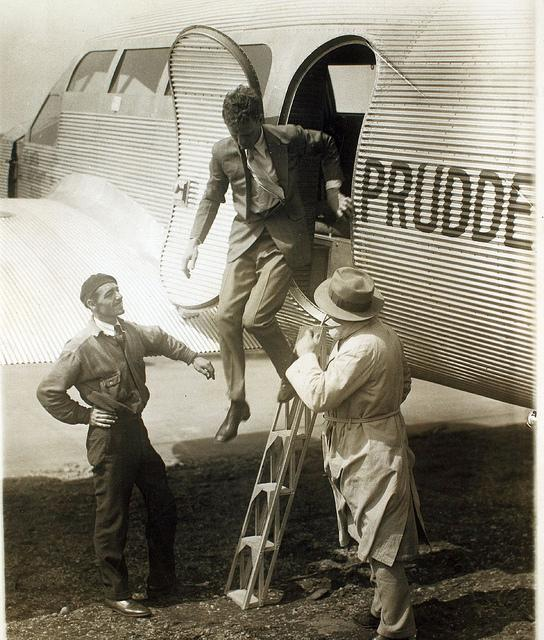

In [146]:
# Construct the file path
file_path = f"/kaggle/input/dataset-vr/Dataset_VR/Images/{num}.jpg"

# Open the image file
img = Image.open(file_path)

# Display the image
display(img)

In [143]:
temp=train_length+3995
questions[temp]

'How many men are wearing hats?'

In [144]:
answers[temp]

'1'

In [142]:
j=3995
print(reverse_label_map[predicted_classes[j]])
print(reverse_label_map[true_classes[j]])

1
1
